In [3]:
%matplotlib inline
import utils; reload(utils)
from random import randint
from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [4]:
path = 'data/fishes/'
full_path = os.getcwd() + '/' + path

In [5]:
batch_size = 64

In [6]:
VERSION = 'fcn_004'

### To do list:

1. Create validation set and sample
2. Move to separate dirs for each set
3. Finetune and train
4. Submit to kaggle

# Create validation set and sample

In [71]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

# Fully conv net (FCN)

In [199]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 3214 images belonging to 8 classes.
Found 563 images belonging to 8 classes.
Found 3214 images belonging to 8 classes.
Found 563 images belonging to 8 classes.
Found 154 images belonging to 1 classes.


First, get the data in our desired format

In [7]:
trn = get_data(path+'train', (360,640))
val = get_data(path+'valid', (360,640))

Found 3214 images belonging to 8 classes.
Found 563 images belonging to 8 classes.


In [200]:
test = get_data(path + 'test', (360, 640))

Found 154 images belonging to 1 classes.


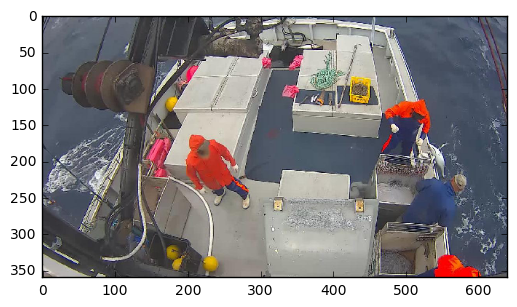

In [18]:
plot(trn[0])

In [20]:
save_array(path+'results/trn_640.dat', trn)
save_array(path+'results/val_640.dat', val)

In [ ]:
save_array(path+'results/test_640_full.dat', test)
#save_array(path+'results/test_640.dat', test)

In [ ]:
trn = load_array(path+'results/trn_640.dat')
val = load_array(path+'results/val_640.dat')
test = load_array(path+'results/test_640_full.dat')

In [14]:
vgg640 = Vgg16BN().model
vgg640 = Vgg16BN((360, 640)).model


In [15]:
vgg640.pop()  # Remove the las maxpooling layer
vgg640.input_shape, vgg640.output_shape

((None, 3, 360, 640), (None, 512, 22, 40))

In [49]:
vgg640.compile(
    Adam(),
    'categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
conv_val_feat = vgg640.predict(val, batch_size=32, verbose=1)
conv_trn_feat = vgg640.predict(trn, batch_size=32, verbose=1)

In [45]:
save_array(path+'results/conv_val_640.dat', conv_val_feat)
save_array(path+'results/conv_trn_640.dat', conv_trn_feat)

In [201]:
conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

154/154 [==============================] - 19s    


In [51]:
save_array(path+'results/conv_test_640_01.dat', conv_test_feat)

In [11]:
conv_val_feat = load_array(path+'results/conv_val_640.dat')
conv_trn_feat = load_array(path+'results/conv_trn_640.dat')

In [52]:
conv_test_feat = load_array(path+'results/conv_test_640_01.dat')

Generate the new CNN part

In [16]:
conv_layers, _ = split_at(vgg640, Convolution2D)

In [17]:
nf = 128
p  = 0

In [18]:
def get_lrg_layers_1():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),

        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        
        Convolution2D(8, 3, 3, border_mode='same'),
        
        # Output layer
        GlobalAveragePooling2D(),
        Activation('softmax'),
    ]

In [19]:
my_model = Sequential(get_lrg_layers_1())

th


In [20]:
my_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_9 (BatchNormal(None, 512, 22, 40)   1024        batchnormalization_input_2[0][0] 
____________________________________________________________________________________________________
convolution2d_44 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_9[0][0]       
____________________________________________________________________________________________________
batchnormalization_10 (BatchNorma(None, 128, 22, 40)   256         convolution2d_44[0][0]           
____________________________________________________________________________________________________
convolution2d_45 (Convolution2D) (None, 128, 22, 40)   147584      batchnormalization_10[0][0]      
___________________________________________________________________________________________

In [58]:
my_model.compile(
    Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [59]:
conv_val_feat.shape

NameError: name 'conv_val_feat' is not defined

In [34]:
my_model.fit(
    conv_trn_feat,
    trn_labels,
    batch_size=batch_size,
    nb_epoch=2,
    validation_data=(conv_val_feat, val_labels))

INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.12-64/lock_dir/lock


Train on 3214 samples, validate on 563 samples
Epoch 1/2
3214/3214 [==============================] - 24s - loss: 0.9503 - acc: 0.7094 - val_loss: 2.5665 - val_acc: 0.5648
Epoch 2/2
3214/3214 [==============================] - 24s - loss: 0.2864 - acc: 0.9216 - val_loss: 0.9920 - val_acc: 0.7762


In [35]:
my_model.optimizer.lr = 1e-5

In [36]:
my_model.fit(
    conv_trn_feat,
    trn_labels,
    batch_size=batch_size,
    nb_epoch=7,
    validation_data=(conv_val_feat, val_labels))

Train on 3214 samples, validate on 563 samples
Epoch 1/7
3214/3214 [==============================] - 24s - loss: 0.1553 - acc: 0.9583 - val_loss: 0.3036 - val_acc: 0.9165
Epoch 2/7
3214/3214 [==============================] - 24s - loss: 0.0715 - acc: 0.9816 - val_loss: 0.2261 - val_acc: 0.9467
Epoch 3/7
3214/3214 [==============================] - 24s - loss: 0.0582 - acc: 0.9823 - val_loss: 0.1718 - val_acc: 0.9591
Epoch 4/7
3214/3214 [==============================] - 24s - loss: 0.0266 - acc: 0.9953 - val_loss: 0.1951 - val_acc: 0.9591
Epoch 5/7
3214/3214 [==============================] - 24s - loss: 0.0092 - acc: 0.9988 - val_loss: 0.1750 - val_acc: 0.9698
Epoch 6/7
3214/3214 [==============================] - 24s - loss: 0.0050 - acc: 0.9991 - val_loss: 0.1760 - val_acc: 0.9680
Epoch 7/7
3214/3214 [==============================] - 24s - loss: 0.0055 - acc: 0.9991 - val_loss: 0.1586 - val_acc: 0.9698


In [37]:
my_model.save_weights(path+'models/lrg_nmp_big_{}.h5'.format(VERSION))

In [ ]:
my_model.load_weights(path+'models/lrg_nmp_big_{}.h5'.format(VERSION))

In [28]:
my_model.evaluate(conv_val_feat, val_labels)

NameError: name 'conv_val_feat' is not defined

In [ ]:
classes

# Making heatmaps

In [23]:
l = my_model.layers
conv_fn = K.function(
    [l[0].input, K.learning_phase()],
    l[-3].output)

In [24]:
def get_cm(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640), interp='nearest')

In [25]:
fish_index = 2
inp = np.expand_dims(conv_val_feat[fish_index], 0)
#conv2 = conv_fn([inp,0])[0, 4]
#conv2
np.round(my_model.predict(inp)[0],2), val_labels[fish_index]

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))

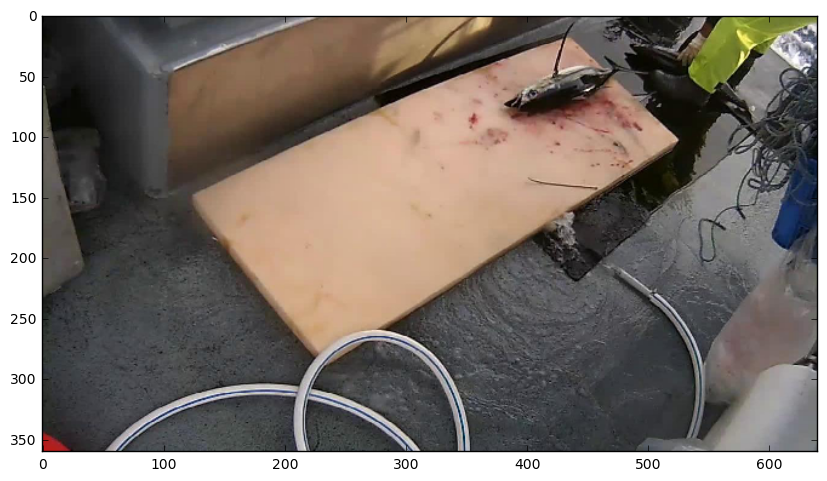

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(to_plot(val[fish_index]))

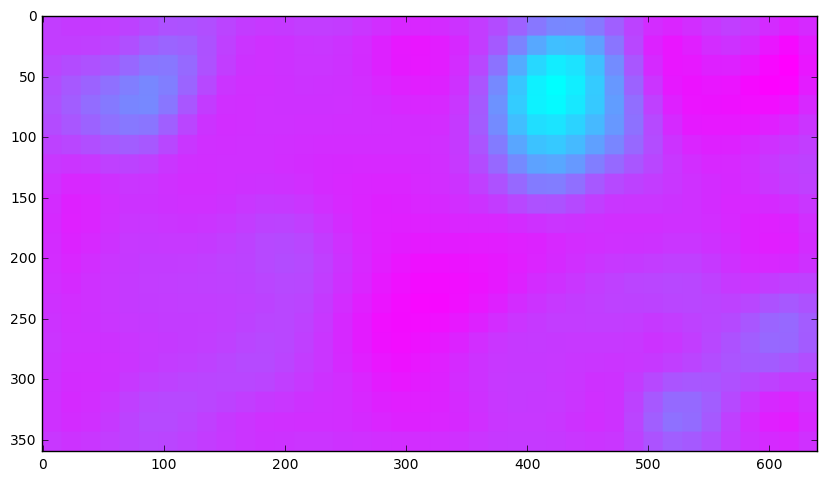

In [31]:
cm = get_cm(inp, 4)
plt.figure(figsize=(10,10))
plt.imshow(cm, cmap='cool')

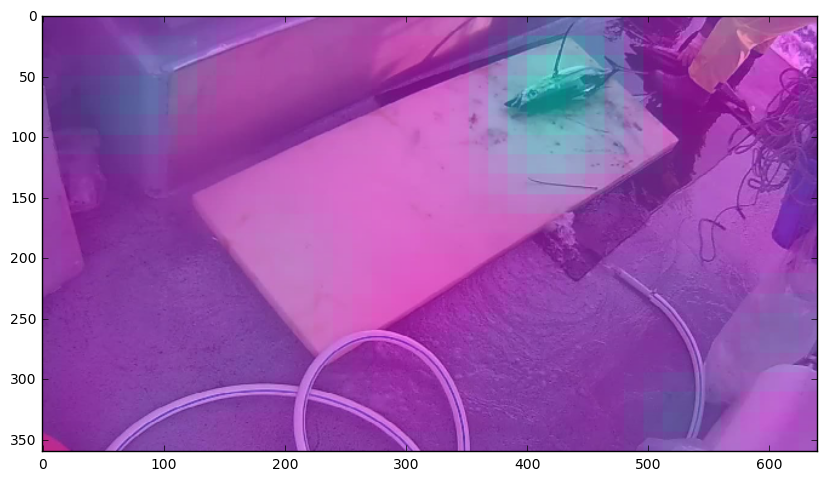

In [32]:
plt.figure(figsize=(10,10))
plot(val[fish_index])
plt.imshow(cm, cmap="cool", alpha=0.5)

## Submit

In [ ]:
test = load_array(path+'results/test.dat')

In [202]:
#test_batches = get_batches(path + 'test', shuffle=False)
preds = my_model.predict(conv_test_feat, batch_size=batch_size)

In [203]:
def do_clip(arr, mx):
    return np.clip(arr, (1-mx)/7, mx)

In [204]:
subm = do_clip(preds, 0.85)
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]


In [205]:
subm_name = path+'results/subm_bb_dp_{}_12.gz'.format(VERSION)

In [206]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,image_12090.jpg,0.360862,0.190257,0.183276,0.021429,0.086306,0.021429,0.127571,0.040198
1,image_12064.jpg,0.703927,0.090654,0.112396,0.021429,0.034743,0.021429,0.050884,0.021429
2,image_12098.jpg,0.653860,0.142856,0.135062,0.021429,0.021429,0.021429,0.037227,0.021429
3,image_12052.jpg,0.592425,0.155660,0.147131,0.021429,0.032857,0.021429,0.062367,0.021429
4,image_12055.jpg,0.542744,0.155954,0.152827,0.021429,0.053753,0.021429,0.075095,0.021429


In [207]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [208]:
FileLink(subm_name)

/home/ubuntu/nbs/data/fishes/results/subm_bb_dp_fcn_004_12.gz